# Linear regression with PyTorch

This is an helper notebook for doing linear regression with PyTorch. You can use this as starting point also for Assignment 1.

Author. A. Dei Rossi, S. Huber, L. Scarciglia, E. Vercesi

## Goal
Given a bunch of generated data from a function $y = w^* x + b^*$, we want to get learn this function

## Packages

First, import all the packages we need. 

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
print(torch.__version__)

2.8.0+cu128


## Helper functions

We will need some functions to make all the code work. 

First, a function that, given the sample size, the noise , and the true value of $w^*, b^*$, generates some noisy data 

In [2]:
def create_dataset(sample_size=10, sigma=0.1, w_star=1, b_star = 1,
                   x_range=(-1, 1), seed=0):
    # Set the random state in numpy
    torch.manual_seed(seed)
    # Unpack the values in x_range
    x_min, x_max = x_range
    # Sample sample_size points from a uniform distribution
    X = torch.rand(sample_size)
    # Rescale between x_min and x_max 
    X = X * (x_max - x_min) + x_min
    # Compute hat(y)
    y_hat = X * w_star + b_star
    # Compute y (Add Gaussian noise)
    y = y_hat + torch.normal(torch.zeros(sample_size), sigma*torch.ones(sample_size))
    return X, y

## Set the true value of parameters

In [3]:
b_star = 2
w_star = 3

## Generate training, validation and test data
Here, we use different seeds to generate training, validation and test data. Usually, you want around 80% of data for training, 10% for validation and 10% for test. We also set a value $\sigma$. The higher, the more noisy will be the data

In [4]:
num_samples_train = 160
num_samples_validation = 20
num_samples_test = 20

# Set the seed
seed_train = 0
seed_validation = 1
seed_test = 2

# Set a value of noise (=sigma)
sigma = 1.3

# Define x_range
x = (-2, 2)

# Generate train data
X_train, y_train = create_dataset(
    sample_size=num_samples_train, sigma=sigma, w_star=w_star,
    b_star = b_star, x_range=x, seed=seed_train)

# Generate the validation data form the same distribution but with a different seed
X_val, y_val = create_dataset(
    sample_size=num_samples_validation, sigma=sigma, w_star=w_star,
    b_star = b_star, x_range=x, seed=seed_validation)

# Generate the test data form the same distribution but with a different seed
X_test, y_test = create_dataset(
    sample_size=num_samples_validation, sigma=sigma, w_star=w_star,
    b_star = b_star, x_range=x, seed=seed_test)

## Plot the data

We now plot the training, test and validation sets

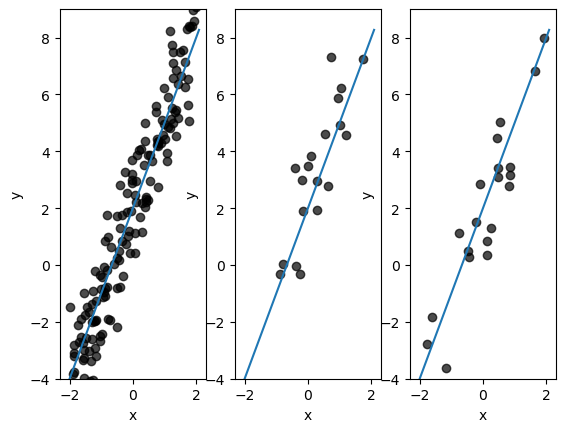

In [5]:
fig, ax = plt.subplots(1, 3) # Create a subplot

# You can use torch directly with numpy
ax[0].plot(X_train, y_train, 'ko', alpha = 0.7)
ax[1].plot(X_val, y_val, 'ko', alpha = 0.7)
ax[2].plot(X_test, y_test, 'ko', alpha = 0.7) 

# Just to have some values in the x-axis
x_range = torch.arange(start=min(x) - 0.1, end=max(x) + 0.1, step=0.01)
for i in range(3):
    ax[i].set_ylim([-4, 9]) # You can see that these limits provide a better visualization
    ax[i].plot(x_range, w_star * x_range + b_star)
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
#plt.show()
# Or...
#plt.savefig("plot.pdf")

## Using GPUs

Now it's time to activate GPUs. Acording to where you are running this notebook, you may want to set something different. 

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(DEVICE)

cuda


## Create the model

It's just a 1-dimensional linear layer, so we can use [`nn.Linear`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

In [7]:
model = nn.Linear(1, 1) # Dimension of input: 1, dimension of output: 1

Recall that is a regression task, so let's use an appropriate loss, such as `MSE `

In [8]:
loss_fn = nn.MSELoss() 

Among the hyperparameters, one of the most important, if not the most important, is the learning rate. 

In [9]:
learning_rate = 0.5

Let's now define an optimizer. We will go with Stochastic Gradient Descend (SGD). Recall: no epochs, just steps. So we update the gradient on the whole dataset.

In [10]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## Training phase

What happens at the very beginning. Parameters are initialized at random, and the prediction are just random guesses

In [11]:
print("Initial w:", model.weight, "Initial b:\n", model.bias)
print("Value in x = 1:", model(torch.tensor([1.]))) # This computes w * 1 + b
print("Actual value in x = 1:", w_star * 1 + b_star)

Initial w: Parameter containing:
tensor([[-0.2032]], requires_grad=True) Initial b:
 Parameter containing:
tensor([0.5817], requires_grad=True)
Value in x = 1: tensor([0.3785], grad_fn=<ViewBackward0>)
Actual value in x = 1: 5


What about loss functions? Recall that we are computing loss on the whole dataset! We note that this value is high.

In [ ]:
# Loss evaluation
initial_loss_function = loss_fn(X_train.reshape(-1, 1), y_train.reshape(-1, 1))
print("Initial loss function:", initial_loss_function)

Initial loss function: tensor(10.6557)


Now we are ready to move everything on the device we chose

In [13]:
X_train = X_train.reshape(-1, 1).to(DEVICE)
print("Note that the tensor we want to use as size")
print(X_train.size())
y_train = y_train.reshape(-1, 1).to(DEVICE)
X_val = X_val.reshape(-1, 1).to(DEVICE)
y_val = y_val.reshape(-1, 1).to(DEVICE)

model = model.to(DEVICE) # Move the model to the device you want to use

Note that the tensor we want to use as size
torch.Size([160, 1])


The training loop is pretty standard, but note that here we do not use epochs, just steps (See lecture 2).

**Question**: Why are we doing `reshape(-1, 1)`? Can we use any other equivalent (or even better) command that we saw during lecture?

Step: 0 - Loss eval: 2.473797559738159
Step: 1 - Loss eval: 2.140022039413452
Step: 2 - Loss eval: 1.88516104221344
Step: 3 - Loss eval: 1.9276336431503296
Step: 4 - Loss eval: 1.9028443098068237
Step: 5 - Loss eval: 1.9111862182617188
Step: 6 - Loss eval: 1.907771348953247
Step: 7 - Loss eval: 1.9090648889541626
Step: 8 - Loss eval: 1.9085601568222046
Step: 9 - Loss eval: 1.9087547063827515


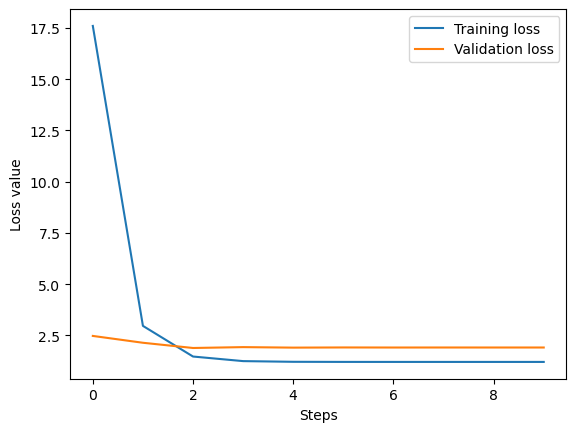

Training done, with an evaluation loss of 1.9087547063827515
Final w: Parameter containing:
tensor([[3.1489]], device='cuda:0', requires_grad=True) Final b:
 Parameter containing:
tensor([1.9972], device='cuda:0', requires_grad=True)


In [14]:
train_loss_vals = []
val_loss_vals = []
n_steps = 10 # Number of updates of the gradient
for step in range(n_steps):
    model.train() # Set the model in training mode
    # Set the gradient to 0
    optimizer.zero_grad() # Or model.zero_grad()
    # Compute the output of the model
    y_hat = model(X_train)
    # Compute the loss
    loss = loss_fn(y_hat, y_train)
    # Compute the gradient
    loss.backward()
    # Update the parameters
    optimizer.step()
    # *** Evaluation ***
    # Here we do things that do not contribute to the gradient computation
    model.eval() # Set the model in evaluation mode
    with torch.no_grad(): #
        # Compute the output of the model
        y_hat_val = model(X_val)
        # Compute the loss
        loss_val = loss_fn(y_hat_val, y_val)
        # Compute the output of the model
        val_loss_vals.append(loss_val.item())
        train_loss_vals.append(loss.item())
        # At every step, print the losses
        print("Step:", step, "- Loss eval:", loss_val.item())
        # Do also a very simple plot
plt.plot(range(step + 1), train_loss_vals)
plt.plot(range(step + 1), val_loss_vals)
plt.legend(["Training loss", "Validation loss"])
plt.xlabel("Steps")
plt.ylabel("Loss value")
plt.show()
print("Training done, with an evaluation loss of {}".format(loss_val.item()))

# Get the final value of the parameters
print("Final w:", model.weight, "Final b:\n", model.bias)

**Questions** : (i) what happens if you do not reshape `y_train, y_val, y_test`? (ii) Can you observe some particular behaviour if you change `sigma` or `learning_rate`?

## Test set 

We want now to qualitatively assess our prediction on the test set. 

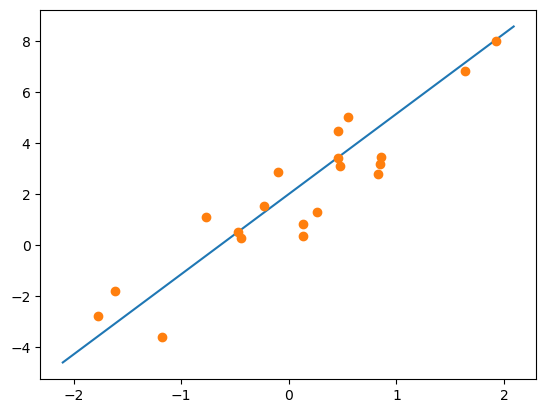

In [15]:
plt.figure()
w_pred = float(model.weight.detach())
b_pred = float(model.bias.detach())
# Plot the points on the test set 
x_range = torch.arange(start=min(x) - 0.1, end=max(x) + 0.1, step=0.01)
plt.plot(x_range, w_pred * x_range + b_pred, '-')
plt.plot(X_test, y_test, 'o')
plt.show()

**Question**: what does it happen without `detach`?

## A comparison with `scikit-learn`

In [16]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train.to('cpu').numpy(),
y_train.to('cpu').numpy())
print("Final w:", reg.coef_, "Final b:\n", reg.intercept_)

Final w: [[3.149102]] Final b:
 [1.9971294]
